# Clasificacion de contribucion al construir de chile

In [1]:
!pip install transformers datasets
!pip install transformers==4.17
!pip install wget
!pip install scikit-plot
!pip install accelerate -U

  Using cached datasets-2.13.1-py3-none-any.whl (486 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.1 MB/s eta 0:00:00


## Imports

In [2]:
import numpy as np

from keras.preprocessing.text import one_hot, Tokenizer
from keras.utils import pad_sequences, plot_model, to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.callbacks import EarlyStopping
from keras.layers import Embedding, LSTM, SpatialDropout1D

from torch.utils.data import Dataset
from datasets import load_dataset, DatasetDict, Dataset, list_metrics, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from scikitplot.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

from transformers import AutoModelForSequenceClassification
from transformers import RobertaTokenizer
from transformers import TFRobertaModel
from transformers import AutoTokenizer, AutoModelWithLMHead
from gensim.models.keyedvectors import KeyedVectors
import wget


from google.colab import files
import pandas as pd
import csv
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

In [3]:
path_data = 'data'
contributions = pd.read_csv('./{}/training_set_contributions.csv'.format(path_data))
display(contributions)

# Preprocesamiento del dataset
labels_unique = contributions['category'].unique()
categories = contributions['category'].unique()
contributions['labels'] = contributions['category'].map({nombre: i for i, nombre in enumerate(labels_unique)})

docs = contributions['text'].values
labels = contributions['labels'].values  # Use integer labels

# Division train/val
id_train = np.load('./{}/ids_train.npy'.format(path_data))
id_val = np.load('./{}/ids_val.npy'.format(path_data))
X_train = []
y_train = []
X_val = []
y_val = []

for i in id_train:
    csv_id = int(np.where(contributions['id'] == i)[0])
    X_train.append(docs[csv_id])
    y_train.append(labels[csv_id])

for i in id_val:
    csv_id = int(np.where(contributions['id'] == i)[0])
    X_val.append(docs[csv_id])
    y_val.append(labels[csv_id])

# Asignacion y OneHot encoding
X_train = np.array(X_train)
y_train = tf.one_hot(y_train, depth=len(labels_unique)).numpy()
X_val = np.array(X_val)
y_val = tf.one_hot(y_val, depth=len(labels_unique)).numpy()

,id,text,category
0,0,asistir a dialogos,Participacion
1,1,conversando lo importante que es votar,Participacion
2,2,ayudar a entregar mejores valores a la juventud.,Reciprocidad-Redes
3,4,luchar por igualdad de derecho de las mujeres,Protesta Social
4,5,informarme por redes creibles,Educación y autoeducación
...,...,...,...
25022,27051,participar en organizaciones sociales,Participacion
25023,27052,participando de procesos eleccionarios,Participacion
25024,27053,"participar en procesos eleccionarios, socioedu...",Participacion
25025,27054,"un chile mas justo, entre el pueblo y el gobierno",Educación y autoeducación


In [4]:
#Data set
train_set = {
    'index':id_train,
    'text': X_train,
    'labels': y_train
}
data_train = Dataset.from_dict(train_set)
val_set = {
    'index':id_val,
    'text': X_val,
    'labels': y_val
}
data_val = Dataset.from_dict(val_set)
dataset = DatasetDict({
    "train":data_train,
    "validation":data_val
})

In [5]:
# Asignacion del checkpoint tokenizador
model_checkpoint = "PlanTL-GOB-ES/roberta-base-bne"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Funcion de tokenizar
def tokenize_category(data):
    return tokenizer(data["text"], truncation=True, padding = True)


columns = dataset["train"].column_names
columns.remove("labels")
encoded_dataset = dataset.map (tokenize_category, batched=True,remove_columns = columns)

Downloading:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/831k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/497k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/957 [00:00<?, ?B/s]

Map:   0%|          | 0/16449 [00:00<?, ? examples/s]

Map:   0%|          | 0/8578 [00:00<?, ? examples/s]

In [6]:
num_labels = len(labels_unique)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Downloading:   0%|          | 0.00/613 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-bne were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [7]:
#Metricas
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    labels = np.argmax(labels, axis=1)
    macro_f1 = f1_score(labels, predictions, average='macro')
    return {
        'accuracy': (predictions == labels).mean(),
        'macro_f1': macro_f1,
    }

In [8]:
#Argumentos de trainer
model_name = model_checkpoint.split("/")[-1]

batch_size = 16
num_train_epochs=20
train_dataset = encoded_dataset["train"].shuffle(seed=42)
logging_steps = len(train_dataset) // (2 * batch_size * num_train_epochs)

training_args = TrainingArguments(
    output_dir="results",
    num_train_epochs=num_train_epochs,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=logging_steps,
)


In [9]:
# Llamada al trainer
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer
)

x = trainer.train()


***** Running training *****
  Num examples = 16449
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 20580


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.090400,0.078975,0.826300,0.651922
2,0.058700,0.069392,0.833877,0.712741
3,0.030000,0.070937,0.846351,0.728083
4,0.019100,0.079960,0.846584,0.730696
5,0.013100,0.087902,0.838307,0.724752
6,0.007000,0.094826,0.840056,0.727333
7,0.003000,0.101687,0.842154,0.731026
8,0.003900,0.105967,0.841455,0.727405
9,0.001200,0.111402,0.845652,0.732700
10,0.001000,0.116455,0.846235,0.735073


***** Running Evaluation *****
  Num examples = 8578
  Batch size = 16
Saving model checkpoint to results/checkpoint-1029
Configuration saved in results/checkpoint-1029/config.json
Model weights saved in results/checkpoint-1029/pytorch_model.bin
tokenizer config file saved in results/checkpoint-1029/tokenizer_config.json
Special tokens file saved in results/checkpoint-1029/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 8578
  Batch size = 16
Saving model checkpoint to results/checkpoint-2058
Configuration saved in results/checkpoint-2058/config.json
Model weights saved in results/checkpoint-2058/pytorch_model.bin
tokenizer config file saved in results/checkpoint-2058/tokenizer_config.json
Special tokens file saved in results/checkpoint-2058/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 8578
  Batch size = 16
Saving model checkpoint to results/checkpoint-3087
Configuration saved in results/checkpoint-3087/config.json
Model weights saved

In [17]:
# Asignacion  manual de datos en la tabla, no encontre la documentaicon para sacarlos automaticamente :(
loss_train = [0.096800, 0.062200, 0.028500, 0.019200, 0.015500, 0.007200, 0.008600, 0.004700, 0.001100, 0.004600, 0.002000, 0.000400, 0.000400, 0.000300, 0.000300, 0.002700, 0.000200, 0.000100, 0.000100, 0.000100]


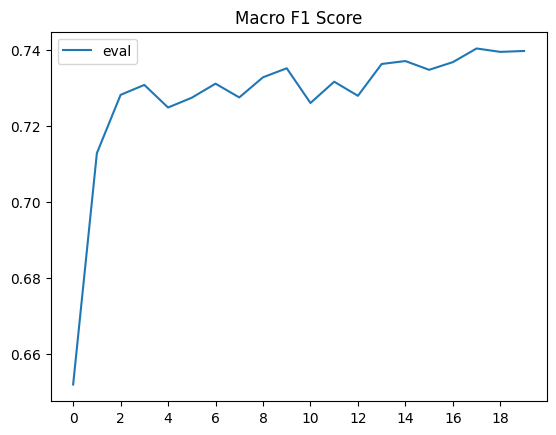

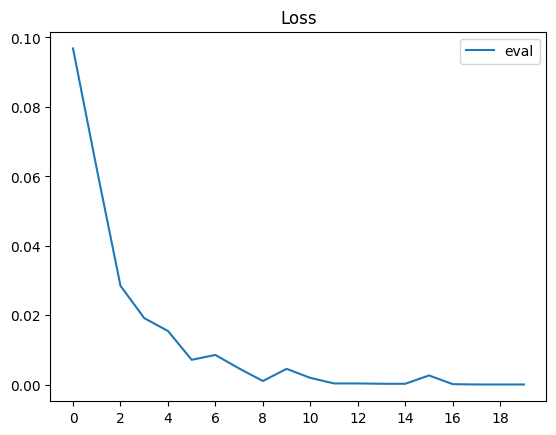

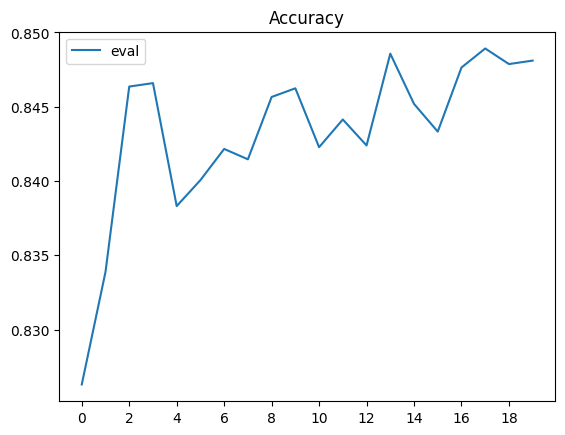

In [33]:
ht = trainer.state.log_history

# Extraer loss, accuracy y F1 de evaluacion de cada epoca
loss_eval = []
accuracy_eval = []
macro_f1_eval = []

for entry in ht:
    if len(entry) > 4:
        loss_eval.append(entry.get('eval_loss'))
        accuracy_eval.append(entry.get('eval_accuracy'))
        macro_f1_eval.append(entry.get('eval_macro_f1'))

# Plot Macro F1 Score
plt.title('Macro F1 Score')
#plt.plot(macro_f1, label='train')
plt.plot(macro_f1_eval, label='eval')
plt.legend()
plt.xticks(range(0, 20,2))
plt.show()

# Plot Loss
plt.title('Loss')
plt.plot(loss_train, label='eval')
#plt.plot(loss_eval, label='eval')
plt.legend()
plt.xticks(range(0, 20,2))
plt.show()

# Plot Accuracy
plt.title('Accuracy')
#plt.plot(accuracy, label='train')
plt.plot(accuracy_eval, label='eval')
plt.legend()
plt.xticks(range(0, 20,2))
plt.show()


In [13]:
# Predicciones sobre el dataset
predictions_train = trainer.predict(encoded_dataset["train"])
y_pred_train = np.argmax(predictions_train.predictions, axis=1)
labels_train = np.argmax(encoded_dataset["train"]["labels"], axis=1)


***** Running Prediction *****
  Num examples = 16449
  Batch size = 16


In [14]:

# Calcular training loss
training_loss = tf.keras.losses.sparse_categorical_crossentropy(labels_train, predictions_train.predictions, from_logits=True).numpy()

# Imprimir the training loss
print("Training Loss:", training_loss)
# Calcular training accuracy
train_accuracy = accuracy_score(labels_train, y_pred_train)

# Calculate training macro F1 score
train_macro_f1 = f1_score(labels_train, y_pred_train, average='macro')

# Print the training accuracy and macro F1 score
print("Training Accuracy:", train_accuracy)
print("Training Macro F1 Score:", train_macro_f1)

Training Loss: [3.5762781e-07 0.0000000e+00 4.2915253e-06 ... 0.0000000e+00 2.3841855e-07
 0.0000000e+00]
Training Accuracy: 1.0
Training Macro F1 Score: 1.0


***** Running Prediction *****
  Num examples = 8578
  Batch size = 16


Macro-F1-Score : 0.7402771360303888


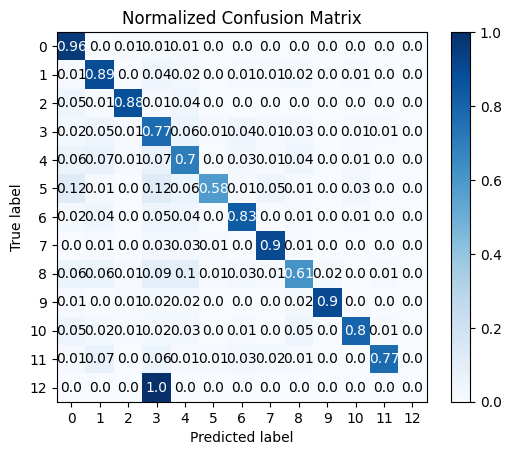

In [15]:
# Predicciones sobre los dato sde validacion
y_pred = trainer.predict(encoded_dataset["validation"]).predictions
y_pred = np.argmax(y_pred, axis=1)

y_val = np.argmax(y_val, axis=1)
macro_f1 = f1_score(y_val, y_pred, average='macro')
print('Macro-F1-Score :', macro_f1)
# Matriz de confucion
plot_confusion_matrix(y_val, y_pred, normalize='pred')
plt.show()

In [16]:

# Inicializacion de datos de testeo
test_contributions = pd.read_csv('./{}/blind_test_set_contributions.csv'.format(path_data))
display(test_contributions)
test_docs = test_contributions['text'].values

val_set = {
    'text': test_docs,
}
data_test = Dataset.from_dict(val_set)
dataset = DatasetDict({
    "test":data_test
})

columns = dataset["test"].column_names
encoded_testset = dataset.map (tokenize_category, batched=True,remove_columns = columns)

# Predicciones del set de testeo
predictions = trainer.predict(encoded_testset["test"])
y_pred_test = np.argmax(predictions.predictions, axis=1)

# Guardar predicciones to CSV
ids_test = np.load('./{}/ids_test.npy'.format(path_data))

headerList = ['ID', 'category']
prediction_data = []
for i, key in enumerate(ids_test):
    max_index = y_pred_test[i]
    category = categories[max_index]
    prediction_data.append({'ID': key, 'category': category})

with open('predicted.csv', 'w', newline='') as f:
    dw = csv.DictWriter(f, fieldnames=headerList)
    dw.writeheader()
    dw.writerows(prediction_data)

# descargar el csv
files.download('predicted.csv')


,id,text
0,27057,- trabajo en negocios atendiendo publico y exp...
1,27060,ir a votar
2,27068,"sororidad entre las mujeres, ser solidarias en..."
3,27086,colaborar con la comunicacion en lugares publicos
4,27099,respetar a los otros/mantener buenas relaciones
...,...,...
2730,54328,comentar sobre mi contribucion a otros para qu...
2731,54340,manifestarme siempre pacificamente
2732,54350,ensenando valores a nuestros hijos para ser me...
2733,54353,"aceptando a todo tipo de personas, sin discrim..."


Map:   0%|          | 0/2735 [00:00<?, ? examples/s]

***** Running Prediction *****
  Num examples = 2735
  Batch size = 16


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>